# Oblique Decision Tree with Proximal Gradient Descent (ISTA)
## Extended: Comparison with k-NN and Random Forest

This notebook implements a high-performance **Sparse Oblique Decision Tree**. Unlike standard CART trees that use axis-aligned splits ($x_i < t$), this tree uses linear combinations of features ($\mathbf{w}^T \mathbf{x} + b < 0$).

### Core Innovations
1.  **Hybrid Optimization:** 
    * **Phase 1 (Selection):** We use `liblinear` (via Scikit-Learn) to rapidly evaluate all valid $2^{K-1}-1$ class bipartitions to find the best splitting hyperplane direction.
    * **Phase 2 (Sparsification):** We refine the winning split using a custom **Proximal Gradient Descent (ISTA)** solver. This enforces L1 regularization, snapping small feature weights to exactly zero for interpretability.
2.  **Global Standardization:** Features are standardized globally at the start to ensure numerical stability in deep nodes where local variance estimates would be noisy.
3.  **Extended Benchmarking:** Rigorous comparison of **4 algorithms**:
    * **CART** - Standard axis-aligned decision tree
    * **Oblique Tree** - Our custom implementation with linear splits
    * **k-NN** - Instance-based lazy learning
    * **Random Forest** - Ensemble of decision trees

### Structure
* **Part 1: Algorithm Implementation** - The math (ISTA), the Tree logic, and the Hybrid Splitting engine.
* **Part 2: Benchmarking** - 4-model comparison on OpenML dataset 44 (Spambase).
* **Part 3: Visualization** - Performance metrics (Accuracy, F1, Precision, Recall), Training times, Radar charts.
* **Part 4: Deep Dive** - Decision boundaries, tree topology, and weight sparsity.

In [2]:
import warnings
import time
from itertools import combinations
from typing import Optional, Dict, Any, List

import numpy as np
import pandas as pd
import openml
from scipy import stats, sparse as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# --- ESSENTIAL IMPORTS ---
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, learning_curve, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs, make_classification
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    matthews_corrcoef,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

# Suppress warnings for clean output (specifically convergence warnings during fast search)
warnings.filterwarnings('ignore')

## PART 1: Algorithm Implementation

### 1.1 The Optimization Engine: ISTA

To create "Concise" splits, we need the feature weights ($\mathbf{w}$) to be sparse. We achieve this using **L1 Regularization (Lasso)**.
Standard Gradient Descent cannot handle the L1 penalty term $\lambda ||\mathbf{w}||_1$ because the absolute value function is not differentiable at 0. 

To solve this, we use the **Iterative Shrinkage-Thresholding Algorithm (ISTA)**:
1.  **Gradient Step:** Update weights based on the smooth Logistic Loss gradient.
    $$\mathbf{w}_{temp} = \mathbf{w}^{(t)} - \eta \nabla \mathcal{L}(\mathbf{w}^{(t)})$$
2.  **Proximal Step (Soft Thresholding):** Apply the "shrinkage" operator.
    $$\mathbf{w}^{(t+1)} = \text{sign}(\mathbf{w}_{temp}) \cdot \max(0, |\mathbf{w}_{temp}| - \eta \lambda)$$

This effectively "snaps" small weights to exactly zero.

In [3]:
# ============================================================================
# HELPER FUNCTIONS: CUSTOM OPTIMIZATION (ISTA)
# ============================================================================

def sigmoid(z):
    # Clip to prevent overflow/underflow in exp
    z = np.clip(z, -20, 20)
    return 1.0 / (1.0 + np.exp(-z))

def soft_threshold(x, lambda_):
    # The Proximal Operator for L1 norm
    return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0.0)

def compute_loss_and_gradients_smooth(X, y, weights, bias):
    n_samples = X.shape[0]
    linear_scores = X @ weights + bias
    probs = sigmoid(linear_scores)
    
    epsilon = 1e-12
    probs_clipped = np.clip(probs, epsilon, 1 - epsilon)
    loss = -np.sum(y * np.log(probs_clipped) + (1 - y) * np.log(1 - probs_clipped)) / n_samples
    
    error = (probs - y) / n_samples
    grad_weights = X.T @ error
    grad_bias = np.sum(error)
    
    return loss, grad_weights, grad_bias

def train_logistic_regression_proximal(X, y, l1_lambda=0.0, max_iterations=100, learning_rate=0.1, tol=1e-5):
    """Solves Logistic Regression with L1 penalty using ISTA."""
    n_samples, n_features = X.shape
    weights = np.zeros(n_features)
    bias = 0.0
    
    for _ in range(max_iterations):
        _, grad_w, grad_b = compute_loss_and_gradients_smooth(X, y, weights, bias)
        
        # 1. Gradient Descent Step
        weights_temp = weights - learning_rate * grad_w
        bias_new = bias - learning_rate * grad_b
        
        # 2. Proximal Step (Soft Thresholding)
        if l1_lambda > 0:
            weights_new = soft_threshold(weights_temp, learning_rate * l1_lambda)
        else:
            weights_new = weights_temp
        
        # Convergence check
        if np.linalg.norm(weights_new - weights) < tol and abs(bias_new - bias) < tol:
            weights, bias = weights_new, bias_new
            break
        
        weights, bias = weights_new, bias_new
            
    return weights, bias

### 1.2 The Splitting Strategy: Hybrid Approach

**The Challenge:** Calculating gradients for $2^{K-1}-1$ partitions in Python is slow.  
**The Solution:** A Hybrid Two-Stage splitting strategy.

1.  **Selection Phase (Speed):** We iterate through all valid class partitions. For each, we use Scikit-Learn's optimized `LogisticRegression` (C++ backend) to find the best hyperplane *without* L1 regularization. We select the partition with the highest Information Gain.
2.  **Refinement Phase (Sparsity):** We take the *winning* partition and re-optimize it using our custom **ISTA** solver with `l1_lambda`. This sparsifies the weights, removing irrelevant features from the split decision.

**Global Standardization:** 
Instead of calculating mean/std at every node (which is unstable on small leaves), we standardize $X$ once globally. The tree stores `global_mean` and `global_std`.

In [4]:
# ============================================================================
# TREE CLASSES 
# ============================================================================

class ObliqueTreeNode:
    def __init__(self, depth: int = 0):
        self.depth = depth
        self.is_leaf = False
        self.predicted_class = None
        self.weights = None
        self.bias = None
        self.left_child = None
        self.right_child = None
        self.n_samples = 0
        self.class_counts = None

class ObliqueDecisionTree(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"
    
    def __init__(self, max_depth=5, min_samples_split=2, min_samples_leaf=1, l1_regularization=0.1, 
                 max_lr_iterations=100, random_state=None, impurity_metric='gini', min_impurity_decrease=0.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.l1_regularization = l1_regularization
        self.max_lr_iterations = max_lr_iterations
        self.random_state = random_state
        self.impurity_metric = impurity_metric
        self.min_impurity_decrease = min_impurity_decrease
        self.root = None
        self.classes_ = None
        # Global scaling parameters to prevent instability in deep nodes
        self.global_mean = None
        self.global_std = None
        
        if random_state is not None:
            np.random.seed(random_state)

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y)
        self.classes_ = np.array(sorted(np.unique(y)))
        
        # Global Standardization (Robustness Fix)
        self.global_mean = X.mean(axis=0)
        self.global_std = X.std(axis=0)
        self.global_std[self.global_std < 1e-8] = 1.0 # Avoid division by zero
        
        X_scaled = (X - self.global_mean) / self.global_std
        
        self.root = self._build_node(X_scaled, y, depth=0)
        return self

    def predict(self, X):
        X = np.array(X, dtype=float)
        # Apply same global scaling
        X_scaled = (X - self.global_mean) / self.global_std
        return self._predict_vectorized(X_scaled, self.root)

    def predict_proba(self, X):
        X = np.array(X, dtype=float)
        X_scaled = (X - self.global_mean) / self.global_std
        proba = self._predict_proba_vectorized(X_scaled, self.root)
        return proba

    def _impurity(self, y):
        if y.size == 0: return 0.0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / counts.sum()
        if self.impurity_metric == 'entropy':
            eps = 1e-12
            return -np.sum(probs * np.log2(probs + eps))
        # Gini
        return 1.0 - np.sum(probs ** 2)

    def _get_ideal_partition_candidates(self, classes):
        cls_list = list(classes)
        if len(cls_list) < 2: return []
        fixed = cls_list[0]
        others = cls_list[1:]
        for r in range(len(others) + 1):
            if r == len(others): continue
            for subset in combinations(others, r):
                yield [fixed] + list(subset)

    def _build_node(self, X, y, depth):
        node = ObliqueTreeNode(depth)
        node.n_samples = X.shape[0]
        
        # Check class purity
        classes, counts = np.unique(y, return_counts=True)
        node.class_counts = dict(zip(classes, counts)) # type: ignore
        majority_class = classes[np.argmax(counts)]

        # Stop Criteria
        if (depth >= self.max_depth or 
            X.shape[0] < self.min_samples_split or 
            X.shape[0] < 2 * self.min_samples_leaf or
            len(classes) == 1):
            node.is_leaf = True
            node.predicted_class = majority_class
            return node

        parent_impurity = self._impurity(y)
        
        # --- HYBRID OPTIMIZATION PHASE 1: SELECTION ---
        # Use optimized Sklearn solver to find the best partition direction quickly
        best_gain = -np.inf
        best_target = None
        fallback_w, fallback_b = None, None # In case ISTA kills all weights
        
        candidates = self._get_ideal_partition_candidates(classes)
        
        # Pre-instantiate solver. Penalty=None (or l2) for speed.
        solver = LogisticRegression(penalty=None, solver='lbfgs', max_iter=50, random_state=self.random_state)
        
        found_split = False
        
        for group_a in candidates:
            mask_a = np.isin(y, group_a)
            y_bin = mask_a.astype(int)
            
            # Skip trivial splits in this subset
            if len(np.unique(y_bin)) < 2: continue
                
            try:
                solver.fit(X, y_bin)
                scores = solver.decision_function(X)
                left_mask = scores < 0
                
                if left_mask.sum() == 0 or (~left_mask).sum() == 0: continue
                if left_mask.sum() < self.min_samples_leaf or (~left_mask).sum() < self.min_samples_leaf: continue
                
                n = y.size
                gain = parent_impurity - ((left_mask.sum()/n)*self._impurity(y[left_mask]) + 
                                          ((~left_mask).sum()/n)*self._impurity(y[~left_mask]))
                
                if gain > best_gain:
                    best_gain = gain
                    best_target = y_bin
                    fallback_w = solver.coef_[0]
                    fallback_b = solver.intercept_[0]
                    found_split = True
            except:
                continue

        if not found_split or best_gain < self.min_impurity_decrease:
            node.is_leaf = True
            node.predicted_class = majority_class
            return node

        # --- HYBRID OPTIMIZATION PHASE 2: SPARSIFICATION (ISTA) ---
        # Retrain only the best partition with L1 regularization
        final_weights, final_bias = train_logistic_regression_proximal(
            X, best_target, 
            l1_lambda=self.l1_regularization, 
            max_iterations=self.max_lr_iterations
        )
        
        # Robustness: If regularization is too strong and weights become all zero,
        # revert to the unregularized weights found in Phase 1
        if np.all(np.abs(final_weights) < 1e-9):
            final_weights = fallback_w
            final_bias = fallback_b
        
        final_scores = X @ final_weights + final_bias
        final_left_mask = final_scores < 0
        final_right_mask = ~final_left_mask
        
        if (final_left_mask.sum() == 0 or final_right_mask.sum() == 0 or
            final_left_mask.sum() < self.min_samples_leaf or final_right_mask.sum() < self.min_samples_leaf):
            node.is_leaf = True
            node.predicted_class = majority_class
            return node

        node.weights = final_weights # type: ignore
        node.bias = final_bias # type: ignore
        node.predicted_class = majority_class
        node.left_child = self._build_node(X[final_left_mask], y[final_left_mask], depth + 1) # type: ignore
        node.right_child = self._build_node(X[final_right_mask], y[final_right_mask], depth + 1) # type: ignore
        return node

    def _predict_vectorized(self, X, node):
        n_samples = X.shape[0]
        if node.is_leaf: return np.full(n_samples, node.predicted_class)
        
        scores = X @ node.weights + node.bias
        left_mask = scores < 0
        
        y_pred = np.empty(n_samples, dtype=int)
        if np.any(left_mask): 
            y_pred[left_mask] = self._predict_vectorized(X[left_mask], node.left_child)
        if np.any(~left_mask): 
            y_pred[~left_mask] = self._predict_vectorized(X[~left_mask], node.right_child)
        return y_pred

    def _predict_proba_vectorized(self, X, node):
        n_samples = X.shape[0]
        # Ensure we have all classes accounted for
        all_classes = self.classes_ 
        proba = np.zeros((n_samples, len(all_classes))) # type: ignore
        self._fill_proba(X, node, proba, np.arange(n_samples), all_classes)
        return proba

    def _fill_proba(self, X, node, proba, idxs, all_classes):
        if len(idxs) == 0: return
        if node.is_leaf:
            counts = node.class_counts or {}
            total = sum(counts.values())
            if total > 0:
                for cls_idx, cls in enumerate(all_classes):
                    # Raw probability (no Laplace smoothing) for fair AUC against CART
                    proba[idxs, cls_idx] = counts.get(cls, 0) / total
            return
        
        X_sub = X[idxs]
        scores = X_sub @ node.weights + node.bias
        left_mask = scores < 0
        if np.any(left_mask): self._fill_proba(X, node.left_child, proba, idxs[left_mask], all_classes)
        if np.any(~left_mask): self._fill_proba(X, node.right_child, proba, idxs[~left_mask], all_classes)


## Part 2: Data Understanding
### 2.1 Dataset: Spam vs Non-spam (class balance)



In [1]:
def load_openml_44():
    """Load OpenML dataset 44 (Spambase) as a raw pandas DataFrame.

    IMPORTANT: we avoid fitting any preprocessing (imputation/encoding/scaling)
    here. Preprocessing is done inside cross-validation via a Pipeline to
    prevent data leakage.
    """
    try:
        dataset = openml.datasets.get_dataset(44)
        target_attr = dataset.default_target_attribute or 'class'
        X_df, y, categorical, _ = dataset.get_data(dataset_format='dataframe', target=target_attr)

        y_ser = pd.Series(y)  # type: ignore
        y_enc = LabelEncoder().fit_transform(y_ser)
        name = dataset.name or 'OpenML_44'
        return X_df, y_enc, name, len(np.unique(y_enc))
    except Exception:
        return None

data = load_openml_44()
if data is None:
    raise RuntimeError('Failed to load OpenML dataset 44')
X_df, y, name, n_classes = data
y_ser = pd.Series(y)
counts = y_ser.value_counts().sort_index()
pct = counts / counts.sum() * 100
labels = ['Non-spam (0)', 'Spam (1)'] if set(counts.index.tolist()) <= {0,1} else [str(i) for i in counts.index.tolist()]
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, pct.values, color=['#95a5a6', '#e74c3c'][:len(labels)], edgecolor='black', alpha=0.85)
ax.set_ylabel('Percentuale (%)')
ax.set_title(f'Class balance: {name}')
ax.set_ylim(0, 100)
ax.grid(True, axis='y', alpha=0.3)
for b, p, c in zip(bars, pct.values, counts.values):
    ax.text(b.get_x() + b.get_width()/2, p + 2, f'{p:.1f}%\n(n={c})', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()


RuntimeError: Failed to load OpenML dataset 44

#### Analysis

The class distribution (approx. 60/40) is **sufficiently balanced** for standard machine learning algorithms. 
While there is a slight skew, it **falls within the acceptable range** where models can learn effectively without requiring synthetic oversampling (like SMOTE) or class weighting. 
We can proceed with standard training, though monitoring F1-score alongside Accuracy remains good practice

### 2.2 Data Description & Quality Check

In [9]:
# 1. Basic Structure
print(f"Shape: {X_df.shape}")
print("Missing Values:", X_df.isnull().sum().sum())
print("Duplicate Rows:", X_df.duplicated().sum())

# 2. Statistical Summary (Transpose for readability)
display(X_df.describe().T.head(10))  # Showing top 10 features

Shape: (4601, 57)
Missing Values: 0
Duplicate Rows: 394


,count,mean,std,min,25%,50%,75%,max
word_freq_make,4601.0,0.104553,0.305358,0.0,0.0,0.0,0.00,4.54
word_freq_address,4601.0,0.213015,1.290575,0.0,0.0,0.0,0.00,14.28
word_freq_all,4601.0,0.280656,0.504143,0.0,0.0,0.0,0.42,5.10
word_freq_3d,4601.0,0.065425,1.395151,0.0,0.0,0.0,0.00,42.81
word_freq_our,4601.0,0.312223,0.672513,0.0,0.0,0.0,0.38,10.00
word_freq_over,4601.0,0.095901,0.273824,0.0,0.0,0.0,0.00,5.88
word_freq_remove,4601.0,0.114208,0.391441,0.0,0.0,0.0,0.00,7.27
word_freq_internet,4601.0,0.105295,0.401071,0.0,0.0,0.0,0.00,11.11
word_freq_order,4601.0,0.090067,0.278616,0.0,0.0,0.0,0.00,5.26
word_freq_mail,4601.0,0.239413,0.644755,0.0,0.0,0.0,0.16,18.18


#### Analysis

The data is structurally clean (no missing values) but **statistically heterogeneous**. The massive difference in scales between "word frequencies" (0.01) and "capital run lengths" (1000+) makes **feature scaling mandatory**. Without the Global Standardization applied in our pipeline, distance-based models (k-NN) and gradient-based optimizations (Oblique Tree) would **fail to converge or be biased toward the larger values**. The presence of duplicates is noted but retained to reflect the real-world probability of receiving identical spam messages.

### 2.3 Correlation Analysis

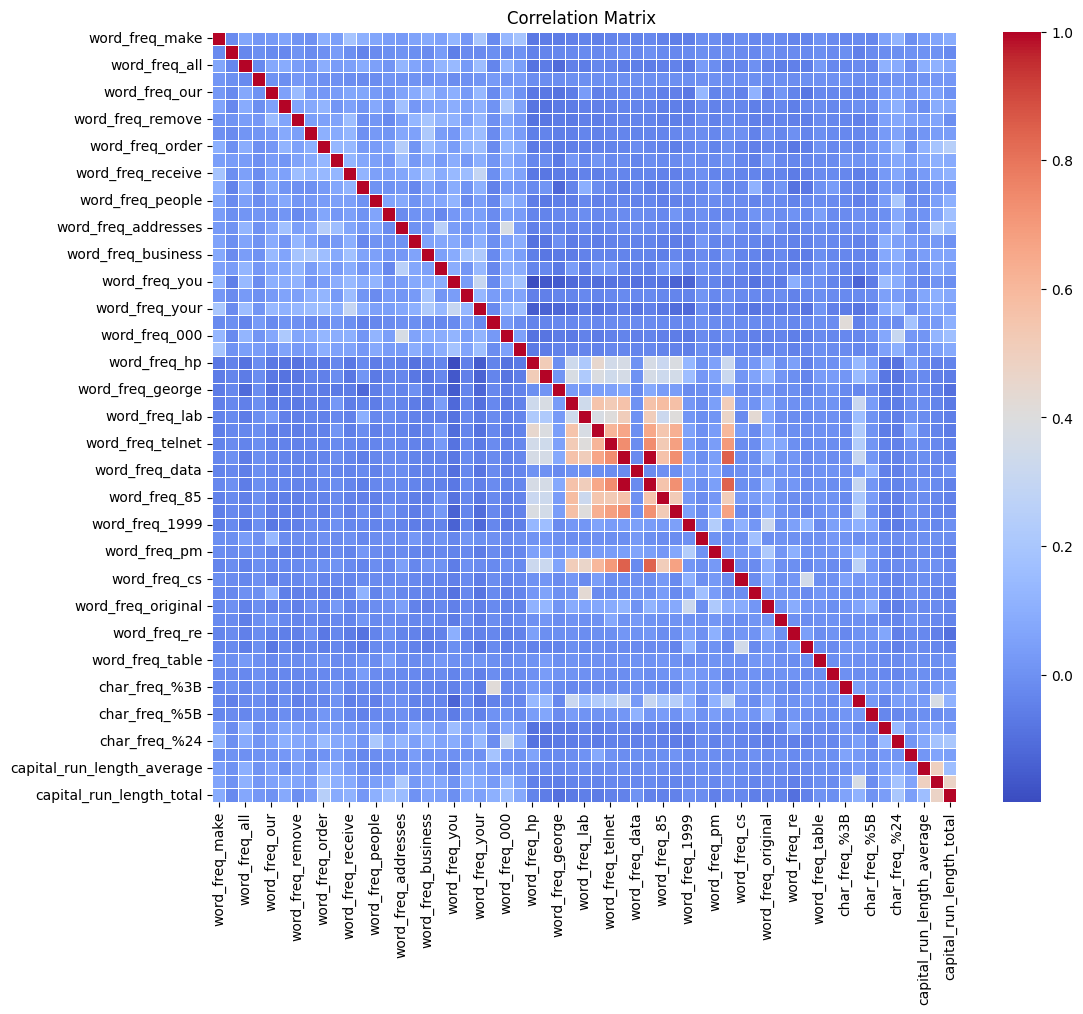

In [12]:
# Compute correlation matrix
corr_matrix = X_df.corr()

plt.figure(figsize=(12, 10))
# Plot heatmap of the first 20 features to avoid clutter
sns.heatmap(corr_matrix.iloc[:57, :57], annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix ")
plt.show()

### Analysis

The dataset exhibits significant multicollinearity. This highlights a critical weakness in standard CART trees: because they can only split on one axis at a time (e.g., if "money" > 0), they struggle to capture relationships between correlated features without creating deep, jagged, and redundant structures. Thus, this correlation structure is the perfect use case for our Oblique Decision Tree.

### 2.4 Feature Distribution

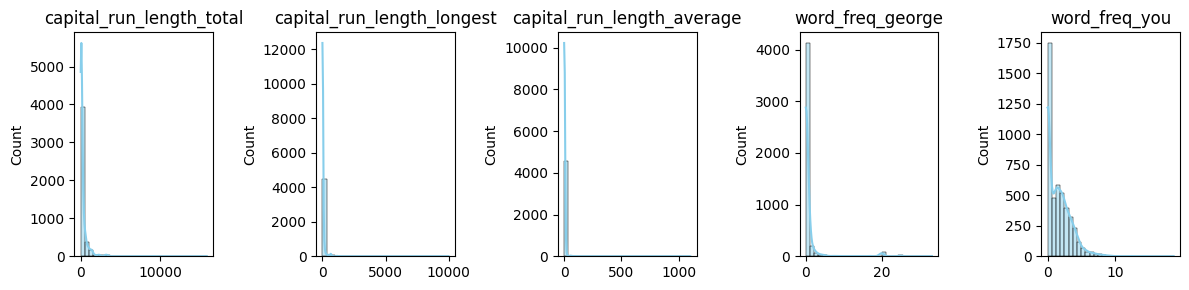

In [16]:
# Plot distributions of the top 4 features with the highest variance
top_var_features = X_df.var().sort_values(ascending=False).head(5).index

plt.figure(figsize=(12, 3))
for i, col in enumerate(top_var_features):
    plt.subplot(1, 5, i+1)
    sns.histplot(X_df[col], bins=30, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
plt.tight_layout()
plt.show()

### Analysis

This distribution creates severe problems for classical statistical models (like Naive Bayes or Linear Regression) that assume normality. However, it validates our choice of Tree-based models (CART, Random Forest, Oblique), which are non-parametric and handle skewed, non-linear data naturally by simply finding a split point in the tail.

The optimization challenge with this data: While trees handle skew well, the internal solver of our Oblique Tree (Logistic Regression + ISTA) uses gradients. Gradients can be unstable on long-tailed data (a value of 15,000 creates a massive gradient compared to 0.1). This reinforces why our Global Standardization step is mathematically essential to compress these long tails into a stable range for the solver.

### 2.5 Class Separability

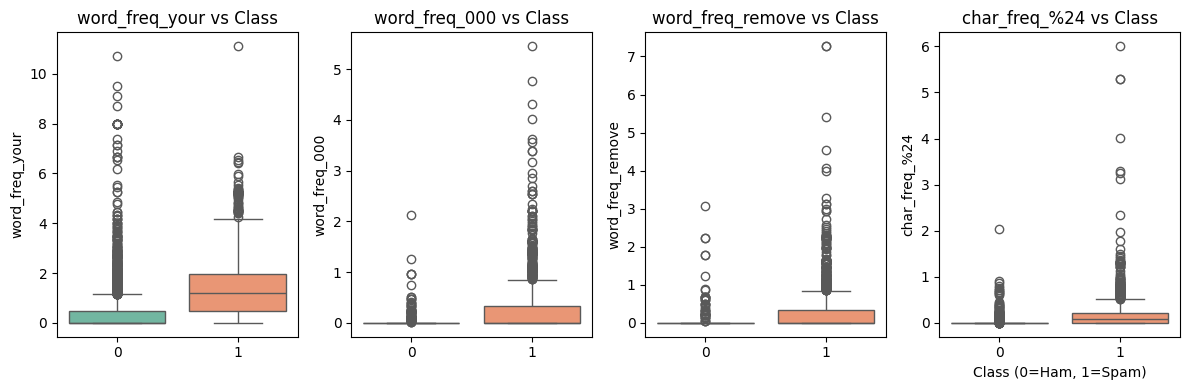

In [17]:
# 1. Find features most correlated with the target
# Combine X and y temporarily for correlation
full_data = X_df.copy()
full_data['target'] = y
correlations = full_data.corr()['target'].abs().sort_values(ascending=False)
top_features = correlations.index[1:5]  # Skip index 0 (which is target itself)

# 2. Plot Boxplots
plt.figure(figsize=(12, 4))
for i, col in enumerate(top_features):
    plt.subplot(1, 4, i+1)
    sns.boxplot(x=y, y=X_df[col], palette='Set2')
    plt.title(f"{col} vs Class")
plt.xlabel("Class (0=Ham, 1=Spam)")
plt.tight_layout()
plt.show()

### Analysis

The clear visual gap between the selected features and the target distributions pproves that most of this words are powerful predictors that will allow the model to easily distinguish between the two classes

### 2.6 Outlier Detection

In [19]:
def detect_outliers_ensemble(X):
    """Detect outliers using 4 complementary methods with consensus voting."""
    try:
        X = np.asarray(X, dtype=float)
        n_samples = X.shape[0]

        # Standardize for outlier detection
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X_std[X_std < 1e-8] = 1.0
        X_norm = (X - X_mean) / X_std

        outlier_flags = np.zeros((n_samples, 4), dtype=int)

        # 1. IQR
        try:
            Q1, Q3 = np.percentile(X_norm, [25, 75], axis=0)
            IQR = Q3 - Q1
            iqr_out = np.any((X_norm < Q1 - 1.5*IQR) | (X_norm > Q3 + 1.5*IQR), axis=1)
            outlier_flags[:, 0] = iqr_out.astype(int)
        except:
            pass

        # 2. Z-score
        try:
            outlier_flags[:, 1] = (np.any(np.abs(X_norm) > 3, axis=1)).astype(int)
        except:
            pass

        # 3. Isolation Forest
        try:
            iso = IsolationForest(contamination='auto', random_state=42)
            outlier_flags[:, 2] = (iso.fit_predict(X_norm) == -1).astype(int)
        except:
            pass

        # 4. LOF
        try:
            lof = LocalOutlierFactor(n_neighbors=min(20, n_samples - 1), contamination='auto')
            outlier_flags[:, 3] = (lof.fit_predict(X_norm) == -1).astype(int)
        except:
            pass

        # Consensus: 2+ methods agree
        consensus_scores = np.sum(outlier_flags, axis=1)
        consensus_outliers = consensus_scores >= 2

        return {
            'ensemble': {
                'outlier_ratio': float(np.mean(consensus_outliers) * 100),
                'agreement_ratio': float(np.mean(np.sum(outlier_flags, axis=1) >= 2))
            }
        }
    except Exception:
        return {'ensemble': {'outlier_ratio': 0.0, 'agreement_ratio': 0.0}}
    
# --- Execute and Report ---

# Apply to the loaded dataset
outlier_metrics = detect_outliers_ensemble(X_df)

print("=" * 40)
print("DATA QUALITY CONCLUSION: OUTLIERS")
print("=" * 40)
print(f"Method: Ensemble Consensus (IQR, Z-score, IsoForest, LOF)")
print(f"Criteria: Flagged by ≥ 2 methods")
print("-" * 40)
print(f"Detected Outliers: {outlier_metrics['ensemble']['outlier_ratio']:.2f}% of dataset")
print("-" * 40)

if outlier_metrics['ensemble']['outlier_ratio'] > 5.0:
    print("⚠️ WARNING: Significant outlier presence (>5%).")
else:
    print("✅ STATUS: Dataset is relatively clean.")

DATA QUALITY CONCLUSION: OUTLIERS
Method: Ensemble Consensus (IQR, Z-score, IsoForest, LOF)
Criteria: Flagged by ≥ 2 methods
----------------------------------------
Detected Outliers: 59.92% of dataset
----------------------------------------
⚠️ WARNING: Significant outlier presence (>5%).


## Part 3: Data Preparation & Modeling (Pipelines)
### Dataset: OpenML ID 44

User-specified benchmark restricted to the OpenML dataset at id 44 (link provided). This binary dataset (between 1k-10k rows, 10-100 features) follows the same preprocessing pipeline: mean imputation for numericals, one-hot encoding for categoricals, 3-fold stratified CV, and the Accuracy/F1/Precision/Recall metrics alongside outlier analysis.


### Methodology Note: Leakage-free preprocessing (Pipeline inside CV)

In cross-validation, every operation that learns from data (imputation, one-hot encoding, scaling, etc.) must be fit **only on the training fold**.
If preprocessing is fit once on the full dataset before CV, information from the test folds can leak into training (data leakage), leading to over-optimistic scores.

To prevent this, we wrap preprocessing + model into a `Pipeline`, and the pipeline is evaluated inside CV. This way, preprocessing is refit separately in each fold.


### Hyperparameter Optimization: Nested Cross-Validation (GridSearchCV)

A single CV estimate can be biased if we tune hyperparameters and evaluate on the same folds.
We therefore use nested CV:
- Outer CV estimates generalization performance.
- Inner CV (`GridSearchCV`) selects hyperparameters on the training split of each outer fold.

This produces a more reliable comparison across algorithms (each model is tuned within the same evaluation protocol).


In [7]:
# ============================================================================
# Data Preparation & Modeling (CART + OBLIQUE + K-NN + RF)
# ============================================================================


def make_preprocessor(X_df: pd.DataFrame):
    """Create a ColumnTransformer to be fit only within CV (via Pipeline)."""
    cat_cols = X_df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    num_cols = [c for c in X_df.columns if c not in cat_cols]

    num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median'))])
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ])

    return ColumnTransformer(
        transformers=[('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)],
        remainder='drop',
        sparse_threshold=0.0,
    )

def count_nodes(node):
    if node is None:
        return 0
    if node.is_leaf:
        return 1
    return 1 + count_nodes(node.left_child) + count_nodes(node.right_child)


def evaluate_dataset(
    X_df, y, name, n_classes,
    outer_splits=5,
    inner_splits=3,
    random_state=42,
    n_jobs=-1,
    scoring='balanced_accuracy',
):
    """Leakage-free benchmark with *nested CV* hyperparameter tuning.

    - Outer CV estimates generalization performance.
    - Inner CV (GridSearchCV) selects hyperparameters.
    - Preprocessing is inside each model Pipeline, so it is fit only on the training fold.

    Returns a dict with mean/std metrics for 4 models.
    """
    X_df = pd.DataFrame(X_df).copy()
    y = np.asarray(y)

    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)

    preprocessor = make_preprocessor(X_df)

    pipe_cart = Pipeline([('preprocess', preprocessor), ('model', DecisionTreeClassifier(random_state=random_state))])
    pipe_obl = Pipeline([('preprocess', preprocessor), ('model', ObliqueDecisionTree(random_state=random_state))])
    pipe_knn = Pipeline([('preprocess', preprocessor), ('scaler', StandardScaler()), ('model', KNeighborsClassifier())])
    pipe_rf = Pipeline([('preprocess', preprocessor), ('model', RandomForestClassifier(random_state=random_state, n_jobs=-1))])

    grids = {
        'cart': {
            'pipe': pipe_cart,
            'params': {
                'model__max_depth': [2, 3, 4, 5, 6, 8, None],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 5],
                'model__ccp_alpha': [0.0, 0.001, 0.01],
            },
        },
        'obl': {
            'pipe': pipe_obl,
            'params': {
                'model__max_depth': [2, 3, 4, 5, 6, 8],
                'model__min_samples_split': [2, 5, 10],
                'model__min_samples_leaf': [1, 2, 5, 10],
                'model__l1_regularization': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2],
                'model__min_impurity_decrease': [0.0, 0.0001, 0.001],
            },
        },
        'knn': {
            'pipe': pipe_knn,
            'params': {
                'model__n_neighbors': [3, 5, 7, 11, 15],
                'model__weights': ['uniform', 'distance'],
                'model__p': [1, 2],
            },
        },
        'rf': {
            'pipe': pipe_rf,
            'params': {
                'model__n_estimators': [200, 500],
                'model__max_depth': [None, 6, 10],
                'model__max_features': ['sqrt', 0.5],
                'model__min_samples_leaf': [1, 2],
            },
        },
    }

    metrics = {
        'cart': {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'time': [], 'nodes': [], 'best_params': []},
        'obl': {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'time': [], 'nodes': [], 'best_params': []},
        'knn': {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'time': [], 'best_params': []},
        'rf': {'acc': [], 'f1': [], 'precision': [], 'recall': [], 'time': [], 'nodes': [], 'best_params': []},
    }

    for train_idx, test_idx in outer_cv.split(X_df, y):
        X_train = X_df.iloc[train_idx]
        X_test = X_df.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]

        for key, cfg in grids.items():
            search = GridSearchCV(
                cfg['pipe'],
                cfg['params'],
                cv=inner_cv,
                scoring=scoring,
                n_jobs=n_jobs,
                refit=True,
                error_score=0.0,
            )
            t0 = time.time()
            search.fit(X_train, y_train)
            elapsed = time.time() - t0

            best = search.best_estimator_
            y_pred = best.predict(X_test)

            metrics[key]['time'].append(elapsed)
            metrics[key]['acc'].append(accuracy_score(y_test, y_pred))
            metrics[key]['f1'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))
            metrics[key]['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            metrics[key]['recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            metrics[key]['best_params'].append(search.best_params_)

            if key == 'cart':
                tree = best.named_steps['model']
                metrics[key]['nodes'].append(int(tree.tree_.node_count))
            elif key == 'obl':
                tree = best.named_steps['model']
                metrics[key]['nodes'].append(int(count_nodes(tree.root)))
            elif key == 'rf':
                rf = best.named_steps['model']
                metrics[key]['nodes'].append(float(np.mean([t.tree_.node_count for t in rf.estimators_])))

    def mean_std(xs):
        xs = np.asarray(xs, dtype=float)
        return float(xs.mean()), float(xs.std(ddof=1)) if len(xs) > 1 else 0.0

    summary = {
        'dataset': name,
        'n_samples': int(len(y)),
        'n_features': int(X_df.shape[1]),
    }

    for key in ['cart', 'obl', 'knn', 'rf']:
        m, s = mean_std(metrics[key]['acc'])
        summary[f'{key}_acc'] = m
        summary[f'{key}_acc_std'] = s

        summary[f'{key}_f1'] = float(np.mean(metrics[key]['f1']))
        summary[f'{key}_precision'] = float(np.mean(metrics[key]['precision']))
        summary[f'{key}_recall'] = float(np.mean(metrics[key]['recall']))

        t_m, t_s = mean_std(metrics[key]['time'])
        summary[f'{key}_time'] = t_m
        summary[f'{key}_time_std'] = t_s

        if metrics[key].get('nodes'):
            summary[f'{key}_nodes'] = float(np.mean(metrics[key]['nodes']))

        try:
            from collections import Counter
            bp = Counter([tuple(sorted(d.items())) for d in metrics[key]['best_params']]).most_common(1)[0][0]
            summary[f'{key}_best_params'] = dict(bp)
        except Exception:
            summary[f'{key}_best_params'] = {}

    return summary


In [8]:
# Run benchmark on the single OpenML dataset (id=44) with 4 models

# Load raw data (no preprocessing fitted here)
data = load_openml_44()
if data is None:
    raise RuntimeError('Failed to load OpenML dataset 44. Ensure network access and valid target column.')

X_df, y, name, n_classes = data

# Fit a *single* preprocessor on the full dataset only for downstream visualizations
# (the benchmark below uses preprocessing *inside* CV via Pipelines)
viz_preprocessor = make_preprocessor(X_df)
X = viz_preprocessor.fit_transform(X_df)

# Header for 4 models
header = f"{'Dataset':<18} {'N':<6} {'Feat':<5} {'CART':<8} {'Oblique':<8} {'k-NN':<8} {'RF':<8} {'Best':<10}"
print(header)
print('=' * len(header))

# Nested CV benchmark (inner grid-search, outer evaluation)
summary = evaluate_dataset(
    X_df, y, name, n_classes,
    outer_splits=5,
    inner_splits=3,
    random_state=42,
    n_jobs=-1,
    scoring='balanced_accuracy',
)

# Build pipelines using the (most frequent) best params from nested CV
preprocessor = make_preprocessor(X_df)
tuned_pipes = {
    'CART': Pipeline([('preprocess', preprocessor), ('model', DecisionTreeClassifier(random_state=42))]),
    'Oblique': Pipeline([('preprocess', preprocessor), ('model', ObliqueDecisionTree(random_state=42))]),
    'k-NN': Pipeline([('preprocess', preprocessor), ('scaler', StandardScaler()), ('model', KNeighborsClassifier())]),
    'RF': Pipeline([('preprocess', preprocessor), ('model', RandomForestClassifier(random_state=42, n_jobs=-1))]),
}

best_params_map = {
    'CART': summary.get('cart_best_params', {}),
    'Oblique': summary.get('obl_best_params', {}),
    'k-NN': summary.get('knn_best_params', {}),
    'RF': summary.get('rf_best_params', {}),
}
for name_m, params in best_params_map.items():
    if isinstance(params, dict) and params:
        tuned_pipes[name_m].set_params(**params)

# Find best model by mean CV accuracy
accs = {'CART': summary['cart_acc'], 'Oblique': summary['obl_acc'], 'k-NN': summary['knn_acc'], 'RF': summary['rf_acc']}
best_model = max(accs, key=accs.get)

print(f"{summary['dataset']:<18} {summary['n_samples']:<6} {summary['n_features']:<5} "
      f"{summary['cart_acc']:.3f}    {summary['obl_acc']:.3f}    {summary['knn_acc']:.3f}    {summary['rf_acc']:.3f}    {best_model}")

print('\n' + '=' * 70)
print('DETAILED RESULTS (nested CV)')
print('=' * 70)

results_data = []
for model, prefix in [('CART', 'cart'), ('Oblique Tree', 'obl'), ('k-NN', 'knn'), ('Random Forest', 'rf')]:
    results_data.append({
        'Model': model,
        'Accuracy': f"{summary[f'{prefix}_acc']:.4f} ± {summary[f'{prefix}_acc_std']:.4f}",
        'F1 (macro)': f"{summary[f'{prefix}_f1']:.4f}",
        'Precision': f"{summary[f'{prefix}_precision']:.4f}",
        'Recall': f"{summary[f'{prefix}_recall']:.4f}",
        'Nested Search Time (s)': f"{summary[f'{prefix}_time']:.4f} ± {summary[f'{prefix}_time_std']:.4f}",
        'Best Params (mode)': str(summary.get(f'{prefix}_best_params', {})),
    })

df_models = pd.DataFrame(results_data)
df_metrics = pd.DataFrame([summary])

# Convenience deltas (mean accuracies)
df_metrics['delta_acc_obl_cart'] = df_metrics['obl_acc'] - df_metrics['cart_acc']
df_metrics['delta_acc_obl_knn'] = df_metrics['obl_acc'] - df_metrics['knn_acc']
df_metrics['delta_acc_obl_rf'] = df_metrics['obl_acc'] - df_metrics['rf_acc']
df_metrics['delta_acc'] = df_metrics['delta_acc_obl_cart']

df_metrics.to_csv('benchmark_results.csv', index=False)
df = df_metrics  # used by downstream plots expecting per-metric columns
print(df_models.to_string(index=False))

print('\n' + '-' * 70)
print('OBLIQUE TREE vs OTHER MODELS (Accuracy Delta, mean CV)')
print('-' * 70)
print(f"  Oblique vs CART:          {df_metrics['delta_acc_obl_cart'].iloc[0]:+.4f}")
print(f"  Oblique vs k-NN:          {df_metrics['delta_acc_obl_knn'].iloc[0]:+.4f}")
print(f"  Oblique vs Random Forest: {df_metrics['delta_acc_obl_rf'].iloc[0]:+.4f}")


Dataset            N      Feat  CART     Oblique  k-NN     RF       Best      


KeyboardInterrupt: 

## PART 4: Performance Visualization

We visualize three key aspects:
1.  **Accuracy Delta:** Does the Oblique tree actually improve performance?
2.  **Precision vs Recall:** Deeper diagnostic insight into type-1 vs type-2 errors.
3.  **Training Cost & Robustness:** Trade-offs with speed and outlier sensitivity.

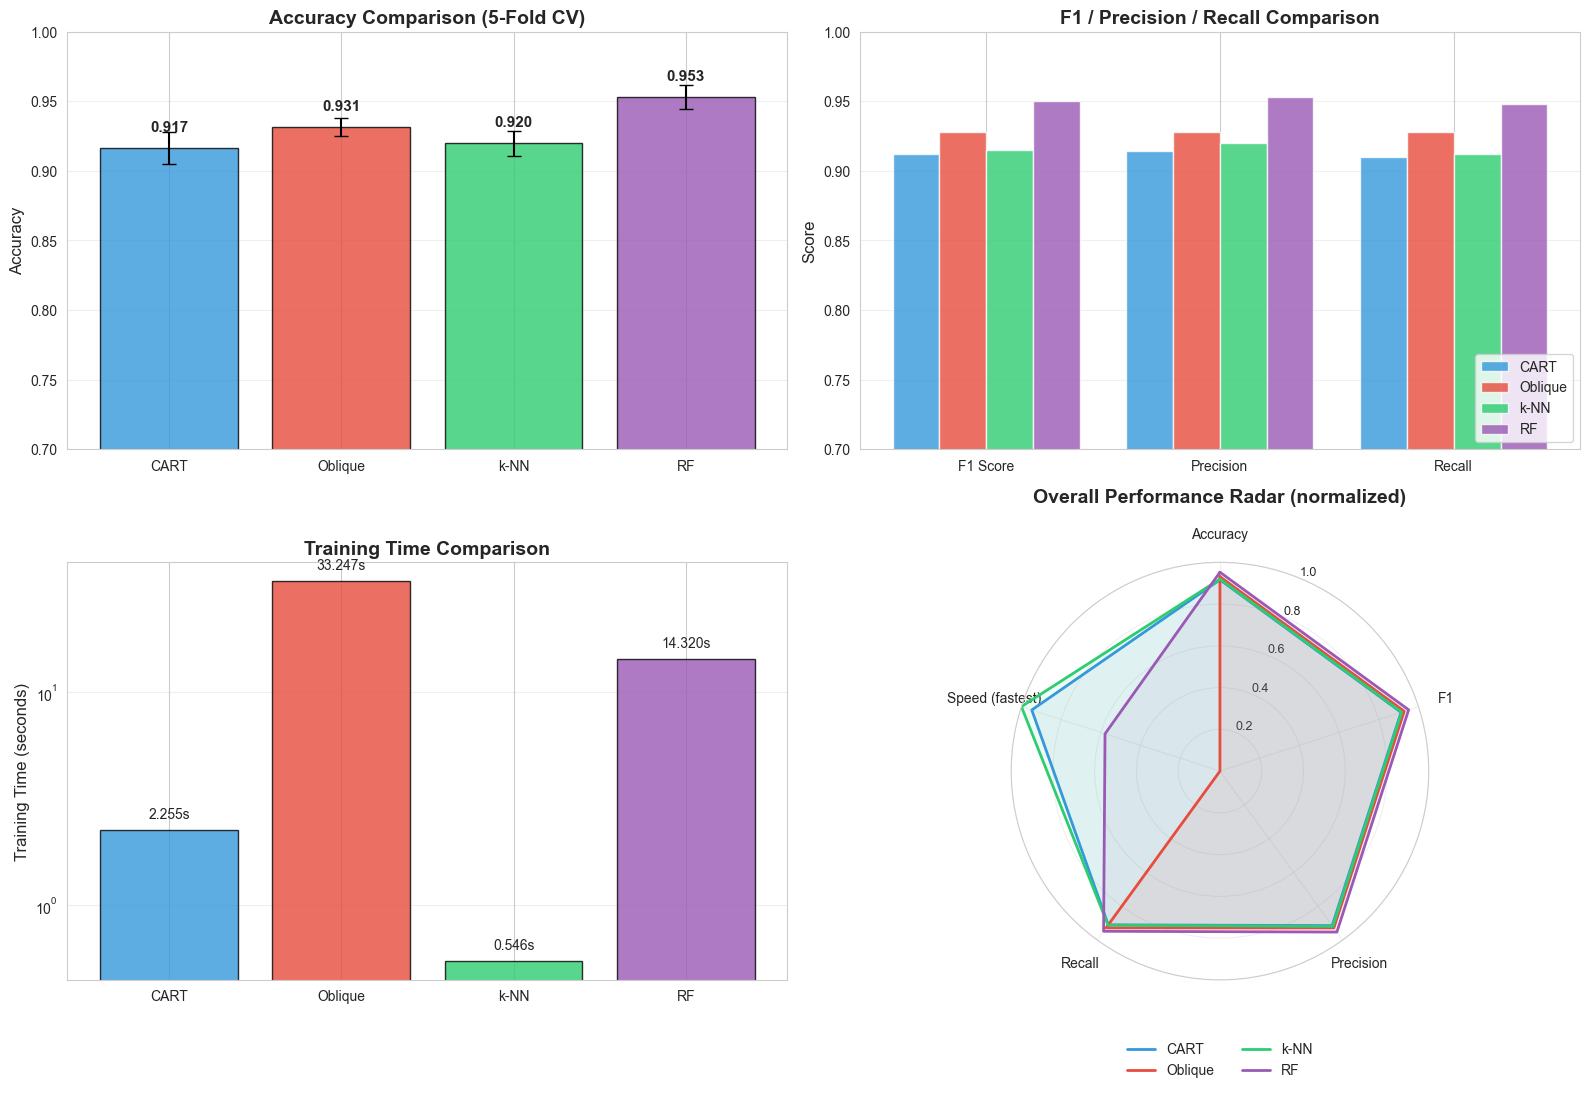


SUMMARY: Best Model per Metric
  Best Accuracy:  RF (0.9528)
  Best F1:        RF (0.9503)
  Best Precision: RF (0.9528)
  Best Recall:    RF (0.9482)
  Fastest:        k-NN (0.5463s)


In [ ]:
# ============================================================================
# VISUALIZATION: 4-MODEL COMPARISON
# ============================================================================

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

# Define colors for all 4 models
COLORS = {
    'CART': '#3498db',      # Blue
    'Oblique': '#e74c3c',   # Red
    'k-NN': '#2ecc71',      # Green
    'RF': '#9b59b6'         # Purple
}

# Alias primary colors for downstream plots
COLOR_CART = COLORS['CART']
COLOR_OBL = COLORS['Oblique']

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ACCURACY COMPARISON (Bar Chart)
ax = axes[0, 0]
models = ['CART', 'Oblique', 'k-NN', 'RF']
accuracies = [summary['cart_acc'], summary['obl_acc'], summary['knn_acc'], summary['rf_acc']]
stds = [summary['cart_acc_std'], summary['obl_acc_std'], summary['knn_acc_std'], summary['rf_acc_std']]
colors = [COLORS[m] for m in models]

bars = ax.bar(models, accuracies, yerr=stds, color=colors, alpha=0.8, capsize=5, edgecolor='black')
ax.set_ylim(0.7, 1.0)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Comparison (5-Fold CV)', fontweight='bold', fontsize=14)
ax.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{acc:.3f}', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# 2. F1 / PRECISION / RECALL COMPARISON
ax = axes[0, 1]
x = np.arange(3)
width = 0.2

metrics_data = {
    'CART': [summary['cart_f1'], summary['cart_precision'], summary['cart_recall']],
    'Oblique': [summary['obl_f1'], summary['obl_precision'], summary['obl_recall']],
    'k-NN': [summary['knn_f1'], summary['knn_precision'], summary['knn_recall']],
    'RF': [summary['rf_f1'], summary['rf_precision'], summary['rf_recall']]
}

for i, (model, values) in enumerate(metrics_data.items()):
    ax.bar(x + i*width, values, width, label=model, color=COLORS[model], alpha=0.8)

ax.set_xticks(x + width*1.5)
ax.set_xticklabels(['F1 Score', 'Precision', 'Recall'])
ax.set_ylim(0.7, 1.0)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('F1 / Precision / Recall Comparison', fontweight='bold', fontsize=14)
ax.legend(loc='lower right')
ax.grid(True, axis='y', alpha=0.3)

# 3. TRAINING TIME COMPARISON (Log Scale)
ax = axes[1, 0]
times = [summary['cart_time'], summary['obl_time'], summary['knn_time'], summary['rf_time']]

bars = ax.bar(models, times, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Training Time (seconds)', fontsize=12)
ax.set_title('Training Time Comparison', fontweight='bold', fontsize=14)
ax.set_yscale('log')
ax.grid(True, axis='y', alpha=0.3)

# Add value labels
for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, f'{t:.3f}s', 
            ha='center', va='bottom', fontsize=10)

# 4. RADAR CHART (Spider Plot) for overall comparison
# Replace the standard axes[1,1] with a polar axis in the same grid slot
fig.delaxes(axes[1, 1])
ax = fig.add_subplot(2, 2, 4, polar=True)

# Prepare data for radar chart
categories = ['Accuracy', 'F1', 'Precision', 'Recall', 'Speed (fastest)']
N = len(categories)

# Normalize speed: 1 = fastest, 0 = slowest
min_time = min(times)
max_time = max(times)
if max_time == min_time:
    speed_scores = [1.0 for _ in times]
else:
    speed_scores = [(max_time - t) / (max_time - min_time) for t in times]

radar_data = {
    'CART': [summary['cart_acc'], summary['cart_f1'], summary['cart_precision'], summary['cart_recall'], speed_scores[0]],
    'Oblique': [summary['obl_acc'], summary['obl_f1'], summary['obl_precision'], summary['obl_recall'], speed_scores[1]],
    'k-NN': [summary['knn_acc'], summary['knn_f1'], summary['knn_precision'], summary['knn_recall'], speed_scores[2]],
    'RF': [summary['rf_acc'], summary['rf_f1'], summary['rf_precision'], summary['rf_recall'], speed_scores[3]],
}

angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), categories, fontsize=10)
ax.tick_params(axis='x', pad=10)

ax.set_ylim(0.0, 1.0)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.grid(alpha=0.3)

for model, values in radar_data.items():
    values = values + values[:1]
    ax.plot(angles, values, linewidth=2, label=model, color=COLORS[model])
    ax.fill(angles, values, alpha=0.08, color=COLORS[model])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
ax.set_title('Overall Performance Radar (normalized)', fontweight='bold', fontsize=14, pad=18)

fig.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()

# Print summary table
print("\n" + "=" * 80)
print("SUMMARY: Best Model per Metric")
print("=" * 80)
print(f"  Best Accuracy:  {max(accs, key=accs.get)} ({max(accs.values()):.4f})")

f1s = {'CART': summary['cart_f1'], 'Oblique': summary['obl_f1'], 'k-NN': summary['knn_f1'], 'RF': summary['rf_f1']}
print(f"  Best F1:        {max(f1s, key=f1s.get)} ({max(f1s.values()):.4f})")

precs = {'CART': summary['cart_precision'], 'Oblique': summary['obl_precision'], 'k-NN': summary['knn_precision'], 'RF': summary['rf_precision']}
print(f"  Best Precision: {max(precs, key=precs.get)} ({max(precs.values()):.4f})")

recs = {'CART': summary['cart_recall'], 'Oblique': summary['obl_recall'], 'k-NN': summary['knn_recall'], 'RF': summary['rf_recall']}
print(f"  Best Recall:    {max(recs, key=recs.get)} ({max(recs.values()):.4f})")

speeds = {'CART': summary['cart_time'], 'Oblique': summary['obl_time'], 'k-NN': summary['knn_time'], 'RF': summary['rf_time']}
print(f"  Fastest:        {min(speeds, key=speeds.get)} ({min(speeds.values()):.4f}s)")


### Learning Curves & Other Comparisons (4 models)



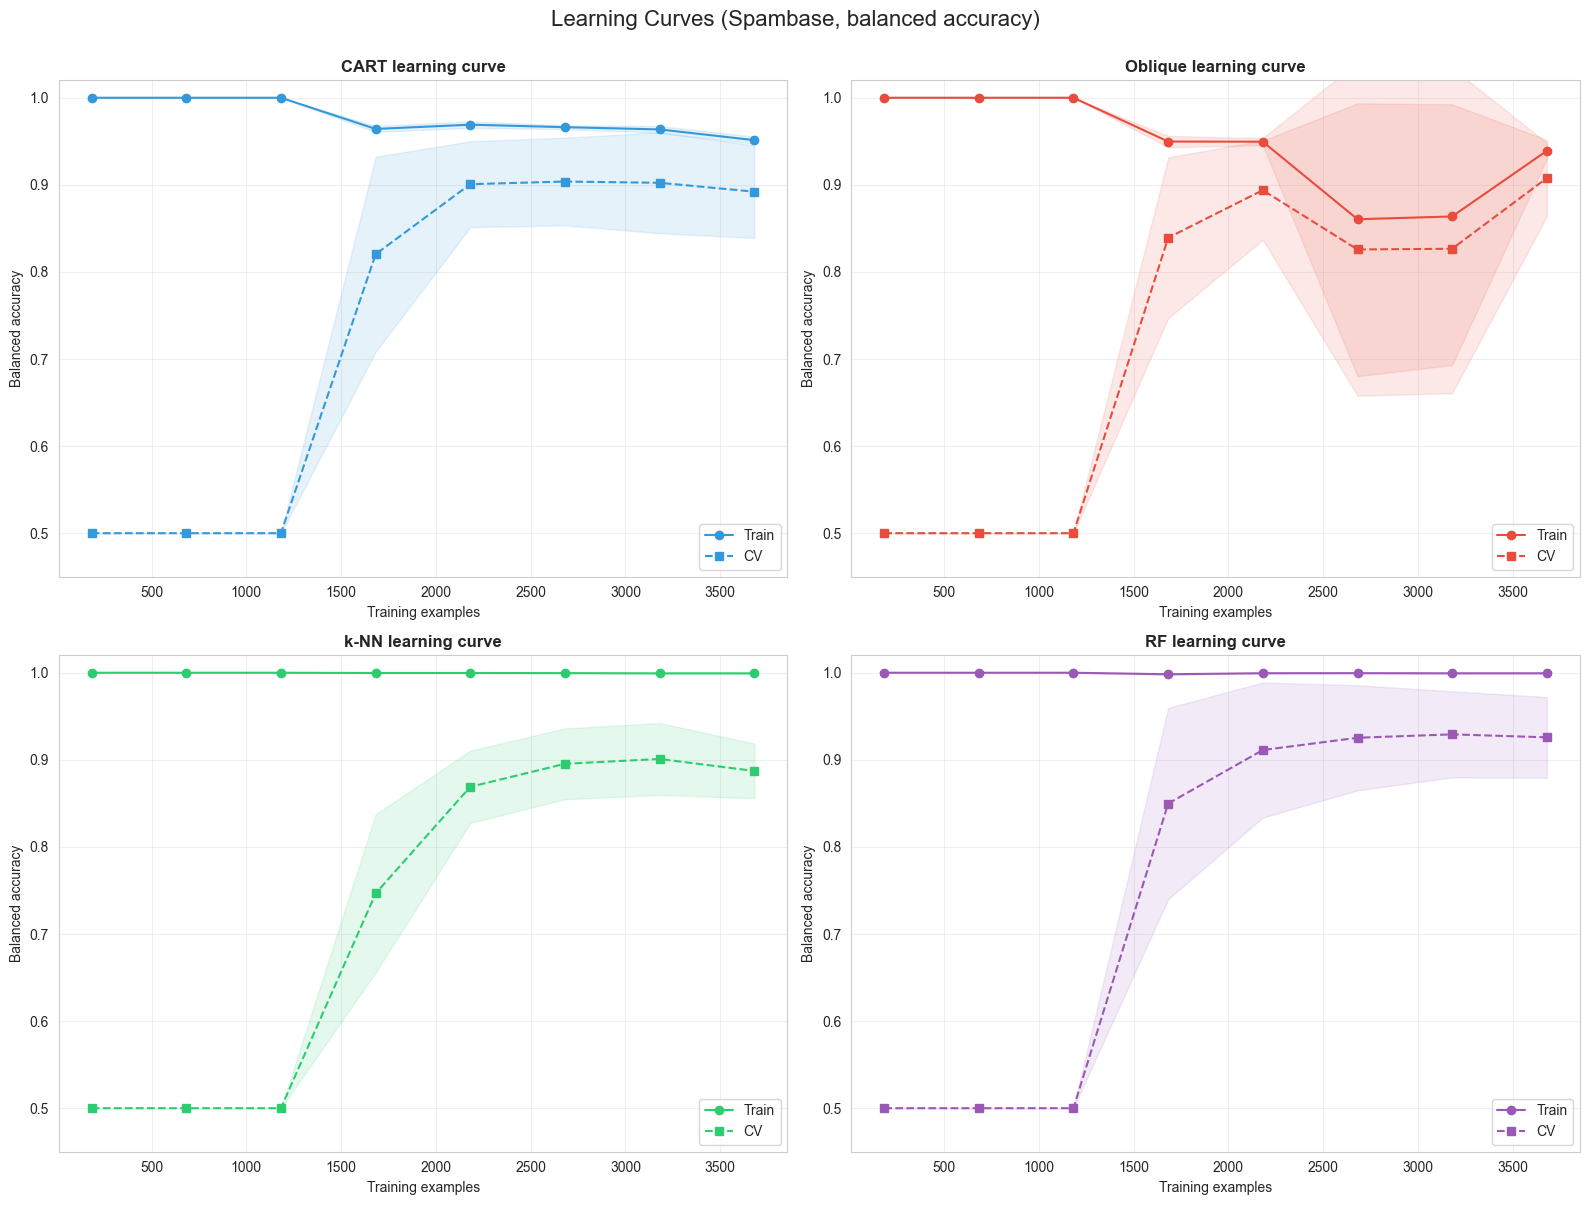

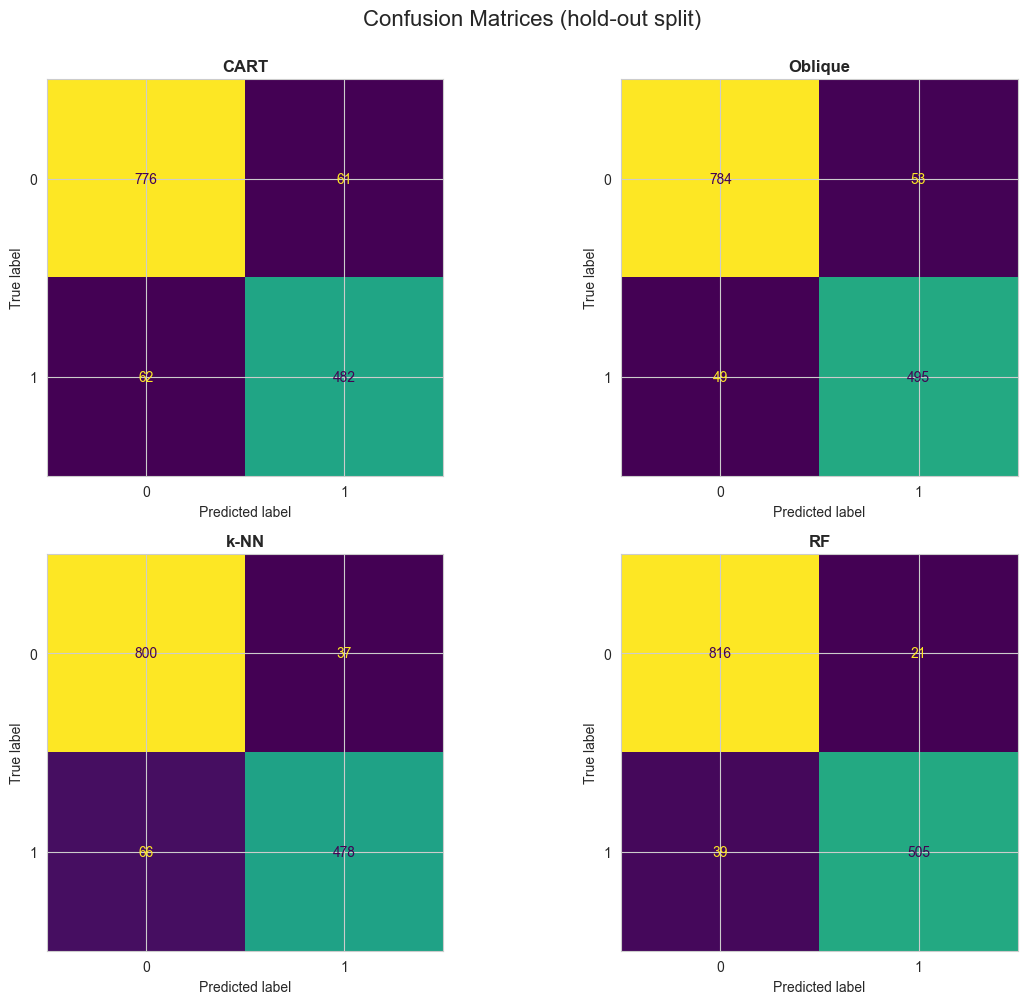

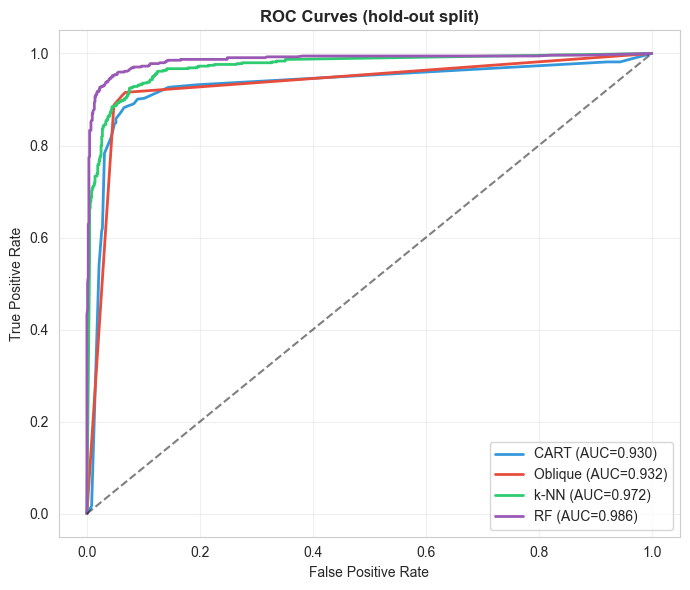

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Ensure we have the real dataset loaded
if 'tuned_pipes' not in globals():
    raise RuntimeError('tuned_pipes not found: run the benchmark cell first')
if 'X' not in globals() or 'y' not in globals():
    data = load_openml_44()
    if data is None:
        raise RuntimeError('Failed to load OpenML dataset 44')
    X_df, y, name, n_classes = data

models_lc = [
    ('CART', tuned_pipes['CART'], COLORS['CART']),
    ('Oblique', tuned_pipes['Oblique'], COLORS['Oblique']),
    ('k-NN', tuned_pipes['k-NN'], COLORS['k-NN']),
    ('RF', tuned_pipes['RF'], COLORS['RF']),
]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()
train_sizes = np.linspace(0.05, 1.0, 8)
cv = StratifiedKFold(n_splits=5)

for ax, (name_m, model, color) in zip(axes, models_lc):
    sizes, train_scores, test_scores = learning_curve(
        model, X_df, y, cv=cv, train_sizes=train_sizes, scoring='balanced_accuracy', n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.12, color=color)
    ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha=0.12, color=color)
    ax.plot(sizes, train_mean, 'o-', color=color, label='Train')
    ax.plot(sizes, test_mean, 's--', color=color, label='CV')
    ax.set_title(f'{name_m} learning curve', fontweight='bold')
    ax.set_xlabel('Training examples')
    ax.set_ylabel('Balanced accuracy')
    ax.set_ylim(0.45, 1.02)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')

plt.suptitle('Learning Curves (Spambase, balanced accuracy)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

# --- Confusion matrices + ROC on a single train/test split (readability) ---
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.30, stratify=y, random_state=42)

models_eval = models_lc

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
for ax, (name_m, model, _) in zip(axes, models_eval):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, colorbar=False)
    ax.set_title(name_m, fontweight='bold')
plt.suptitle('Confusion Matrices (hold-out split)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

# ROC curve (binary only)
if len(np.unique(y)) == 2:
    fig, ax = plt.subplots(figsize=(7, 6))
    for name_m, model, color in models_eval:
        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, proba)
        ax.plot(fpr, tpr, label=f'{name_m} (AUC={auc(fpr,tpr):.3f})', color=color, linewidth=2)
    ax.plot([0,1],[0,1],'k--', alpha=0.5)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves (hold-out split)', fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
else:
    print('ROC plot skipped: dataset is not binary.')


### Decision Boundaries on Spambase (CART vs Oblique)


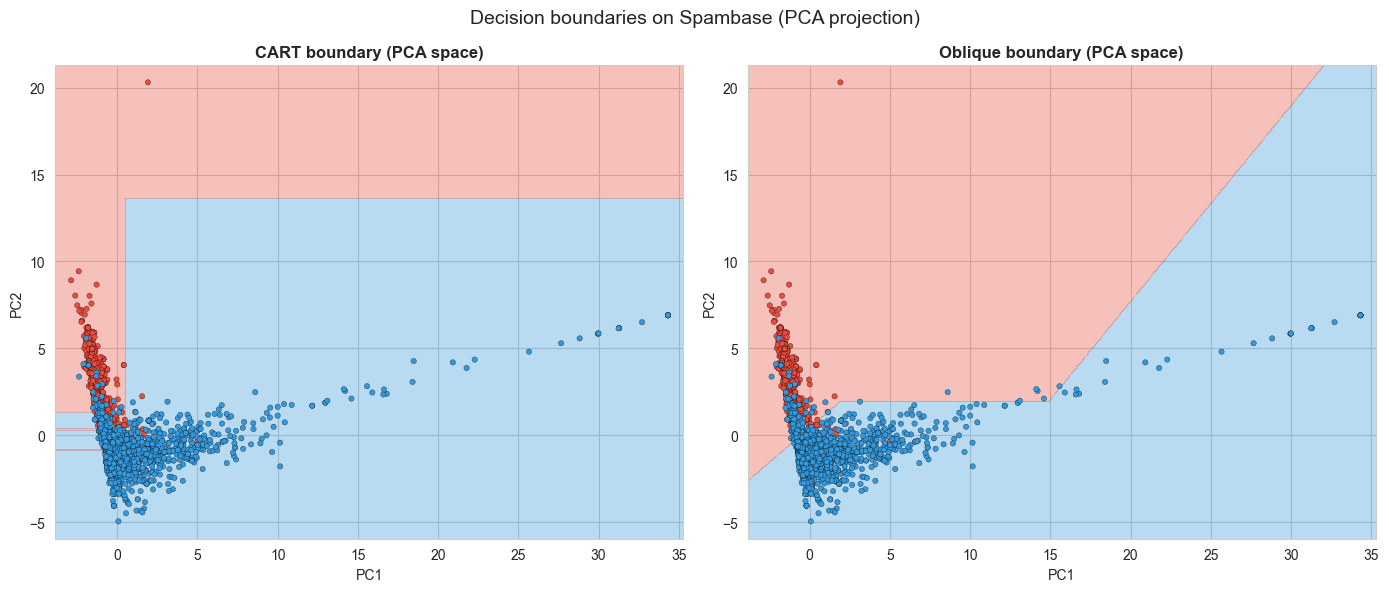

In [ ]:
# Use tuned depths from the benchmark when available
cart_depth = tuned_pipes['CART'].get_params().get('model__max_depth', 3) if 'tuned_pipes' in globals() else 3
obl_depth = tuned_pipes['Oblique'].get_params().get('model__max_depth', 3) if 'tuned_pipes' in globals() else 3
if cart_depth is None: cart_depth = 6
if obl_depth is None: obl_depth = 6

# Project to 2D for visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X_scaled)

cart_2d = DecisionTreeClassifier(max_depth=cart_depth, random_state=42).fit(X2, y)
obl_2d = ObliqueDecisionTree(max_depth=obl_depth, l1_regularization=tuned_pipes['Oblique'].get_params().get('model__l1_regularization', 0.01) if 'tuned_pipes' in globals() else 0.01, random_state=42).fit(X2, y)

h = 0.05
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

Z_cart = cart_2d.predict(grid).reshape(xx.shape)
Z_obl = obl_2d.predict(grid).reshape(xx.shape)

cmap = mcolors.ListedColormap([COLORS['CART'], COLORS['Oblique']])
levels = [-0.5, 0.5, 1.5]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].contourf(xx, yy, Z_cart, alpha=0.35, cmap=cmap, levels=levels)
axes[0].scatter(X2[:, 0], X2[:, 1], c=y, cmap=cmap, s=15, edgecolor='black', linewidth=0.2, vmin=0, vmax=1)
axes[0].set_title('CART boundary (PCA space)', fontweight='bold')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].contourf(xx, yy, Z_obl, alpha=0.35, cmap=cmap, levels=levels)
axes[1].scatter(X2[:, 0], X2[:, 1], c=y, cmap=cmap, s=15, edgecolor='black', linewidth=0.2, vmin=0, vmax=1)
axes[1].set_title('Oblique boundary (PCA space)', fontweight='bold')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.suptitle('Decision boundaries on Spambase (PCA projection)', fontsize=14)
plt.tight_layout()
plt.show()


## PART 5: Advanced Diagnostics

We conclude with a deeper look into the internal workings of the models using a high-dimensional synthetic dataset (10 features: 5 informative, 5 noise).
We analyze:
1.  **Feature Selection:** Can the models distinguish signal from noise?
2.  **Sparsity:** Does the L1 regularization actually produce sparse splits?
3.  **Ranking Performance:** ROC Analysis.

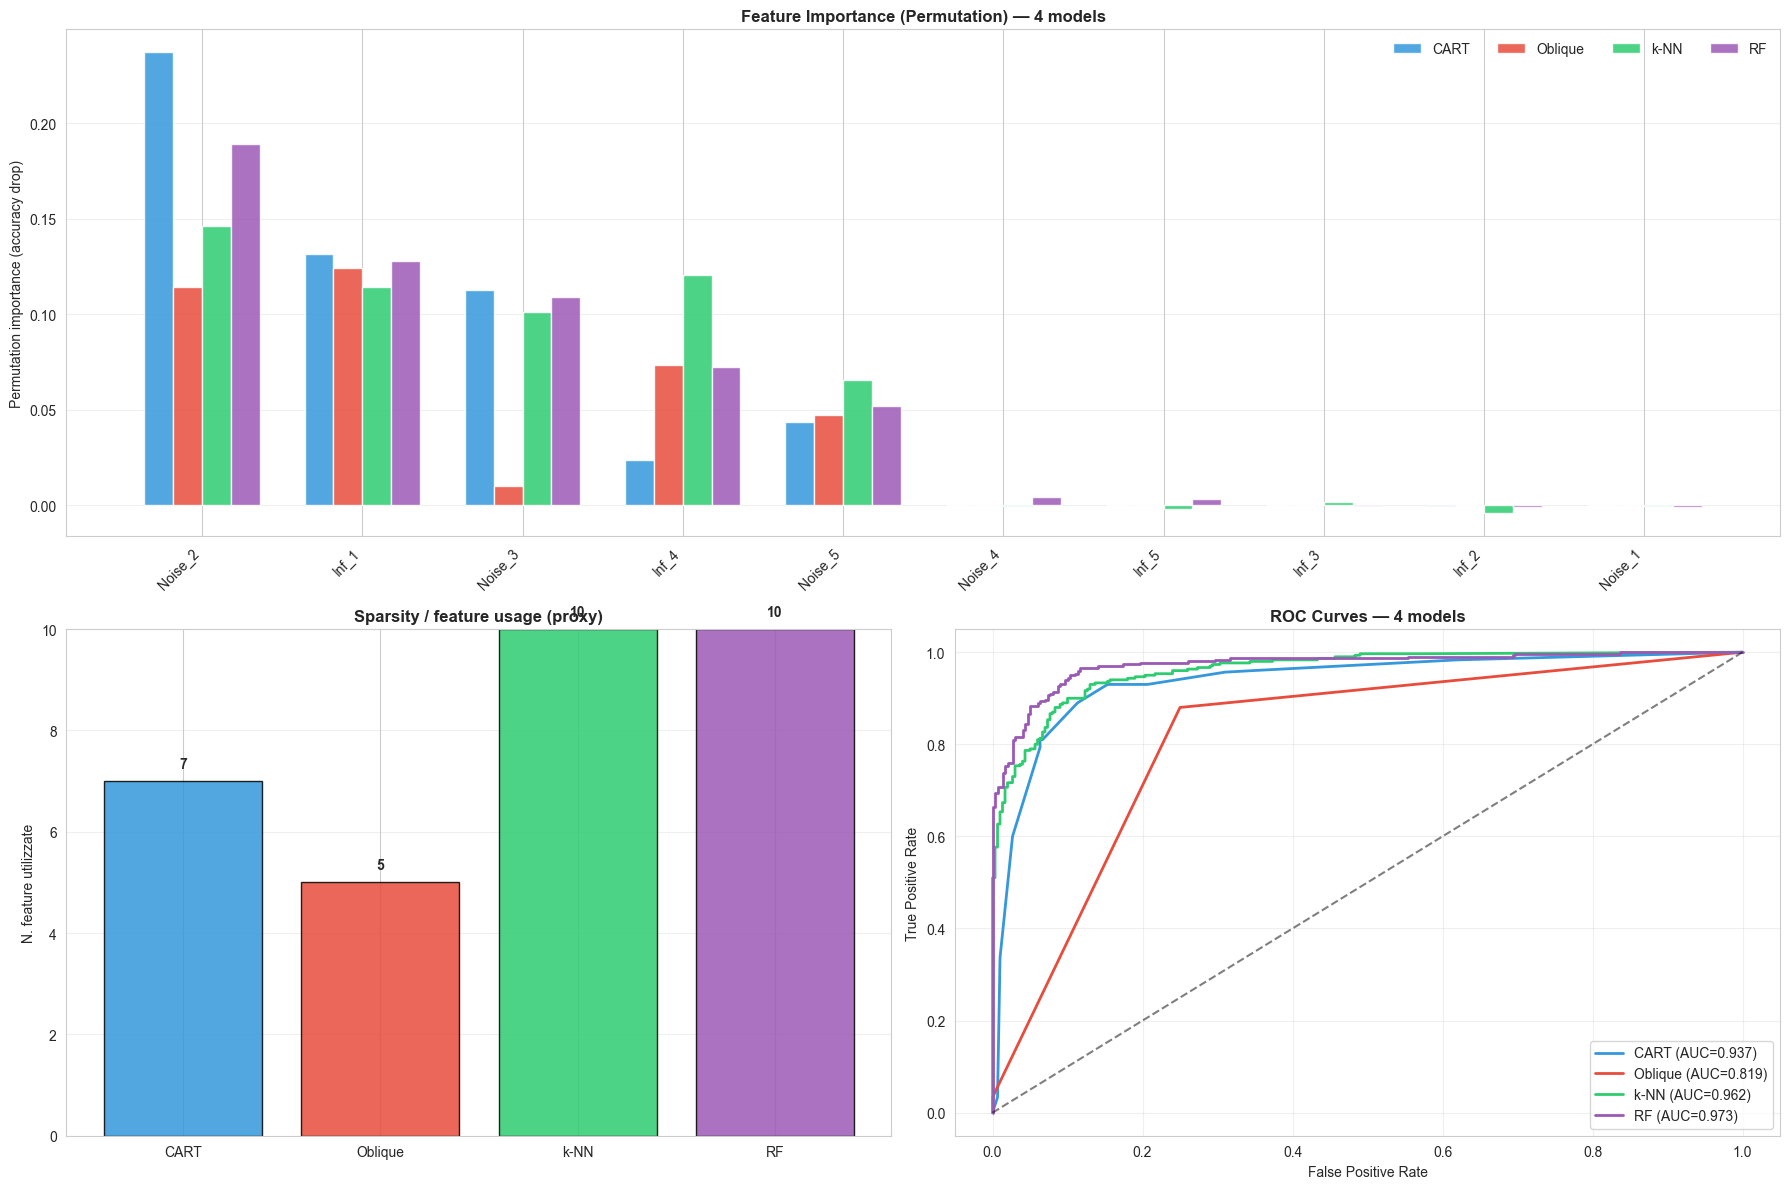

In [ ]:
# ==========================================
# PART 5: ADVANCED DIAGNOSTICS (4 MODELS)
# ==========================================
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline

# Synthetic dataset: 5 informative + 5 noise
X_adv, y_adv = make_classification(
    n_samples=2000, n_features=10, n_informative=5, n_redundant=0, n_repeated=0,
    n_clusters_per_class=2, class_sep=1.2, flip_y=0.03, random_state=42
)
feature_names = [f'Inf_{i+1}' for i in range(5)] + [f'Noise_{i+1}' for i in range(5)]

X_train, X_test, y_train, y_test = train_test_split(
    X_adv, y_adv, test_size=0.30, stratify=y_adv, random_state=42
)

models = {
    'CART': DecisionTreeClassifier(max_depth=5, random_state=42),
    'Oblique': ObliqueDecisionTree(max_depth=5, l1_regularization=0.08, random_state=42),
    'k-NN': make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=9, weights='distance')),	
    'RF': RandomForestClassifier(n_estimators=200, max_depth=8, random_state=42, n_jobs=-1),
}

# Fit
for m in models.values():
    m.fit(X_train, y_train)

# --- Panel A: permutation feature importance (works for all models) ---
importances = {}
for name_m, model in models.items():
    r = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy', n_jobs=-1)
    importances[name_m] = r.importances_mean

# Shared top-k set for readability (top by RF)
top_k = 10
top_idx = np.argsort(importances['RF'])[-top_k:][::-1]
feat_subset = [feature_names[i] for i in top_idx]

# --- Panel B: sparsity/complexity proxy for all 4 ---
def features_used_cart(tree):
    fi = tree.tree_.feature
    used = {int(f) for f in fi if f >= 0}
    return len(used)

def features_used_rf(rf):
    used = set()
    for est in rf.estimators_:
        fi = est.tree_.feature
        used |= {int(f) for f in fi if f >= 0}
    return len(used)

def features_used_oblique(obl):
    used = set()
    def traverse(node):
        if node is None or node.is_leaf:
            return
        nz = np.where(np.abs(node.weights) > 1e-6)[0]
        for j in nz:
            used.add(int(j))
        traverse(node.left_child)
        traverse(node.right_child)
    traverse(obl.root)
    return len(used)

feat_used = {
    'CART': features_used_cart(models['CART']),
    'Oblique': features_used_oblique(models['Oblique']),
    'k-NN': X_train.shape[1],
    'RF': features_used_rf(models['RF']),
}

# --- Panel C: ROC curves (binary) for all 4 ---
roc_data = {}
for name_m, model in models.items():
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_data[name_m] = (fpr, tpr, auc(fpr, tpr))

# --- Plot layout ---
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2)

# A) Feature importance (grouped bars)
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(feat_subset))
width = 0.18
order = ['CART', 'Oblique', 'k-NN', 'RF']
offsets = {'CART': -1.5*width, 'Oblique': -0.5*width, 'k-NN': 0.5*width, 'RF': 1.5*width}
for name_m in order:
    vals = importances[name_m][top_idx]
    ax1.bar(x + offsets[name_m], vals, width, label=name_m, color=COLORS[name_m], alpha=0.85)
ax1.set_xticks(x)
ax1.set_xticklabels(feat_subset, rotation=45, ha='right')
ax1.set_ylabel('Permutation importance (accuracy drop)')
ax1.set_title('Feature Importance (Permutation) — 4 models', fontweight='bold')
ax1.grid(True, axis='y', alpha=0.3)
ax1.legend(ncol=4, frameon=False)

# B) Feature usage / sparsity proxy
ax2 = fig.add_subplot(gs[1, 0])
ax2.bar(order, [feat_used[m] for m in order], color=[COLORS[m] for m in order], edgecolor='black', alpha=0.85)
ax2.set_ylim(0, X_train.shape[1])
ax2.set_ylabel('N. feature utilizzate')
ax2.set_title('Sparsity / feature usage (proxy)', fontweight='bold')
ax2.grid(True, axis='y', alpha=0.3)
for i, m in enumerate(order):
    ax2.text(i, feat_used[m] + 0.2, str(feat_used[m]), ha='center', va='bottom', fontweight='bold')

# C) ROC curves
ax3 = fig.add_subplot(gs[1, 1])
for name_m in order:
    fpr, tpr, a = roc_data[name_m]
    ax3.plot(fpr, tpr, label=f'{name_m} (AUC={a:.3f})', color=COLORS[name_m], linewidth=2)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curves — 4 models', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(loc='lower right')

plt.tight_layout()
plt.show()


### Analysis: Advanced Diagnostics (4 models)

1. **Permutation Feature Importance (Top):** confronto uniforme tra i 4 modelli su feature informative vs rumore.
2. **Sparsity / Feature usage (Bottom-Left):** proxy di quante feature vengono effettivamente usate.
3. **ROC Curves (Bottom-Right):** confronto AUC tra i 4 modelli (dataset sintetico binario).


### Interpretation of Advanced Diagnostics

- Nel plot di importanza, le feature `Inf_*` dovrebbero dominare rispetto a `Noise_*` per un buon modello.
- Nel plot di sparsità, l’Oblique può usare meno feature grazie alla regolarizzazione L1; k-NN tende a usare tutte le feature.
- Nelle ROC, AUC più alta indica migliore ranking delle probabilità.


---
## References

### Dataset
- Hopkins, M., Reeber, E., Forman, G., & Suermondt, J. (1999). **Spambase Dataset**. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/94/spambase

### Related Research
- Rusland, N.F., et al. (2017). A Comparative Study for Spam Classifications. https://www.researchgate.net/publication/340096186
- Int. Journal of Information Security (2023). Ensemble Methods for Spam Detection. https://link.springer.com/article/10.1007/s10207-023-00756-1
- Knowledge-Based Systems (2008). Content-Based Dynamic Spam Classification. https://www.sciencedirect.com/science/article/abs/pii/S0950705108000026

### Libraries
- Scikit-learn: https://scikit-learn.org/
- UCI ML Repository: https://archive.ics.uci.edu/
- Pandas, NumPy, Matplotlib, Seaborn